<a href="https://colab.research.google.com/github/OluwatobaAdeoye/CNN-and-LSTM/blob/main/Keras_Assignment_Dec2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CW1 - Multimodal IMDB Analysis with Keras

## Introduction

In this assignment you will be provided a dataset containing a selection of films together with their posters in JPEG image format and their overviews in text format from the Internet Movie Database.

![Example](https://i.ibb.co/J3trT62/Screenshot-2024-09-22-214753.png)

You will be analysing this dataset by implementing and training two models: a **CNN** and an **LSTM**.

The CNN must classify film posters by the genre. Independently, the LSTM must classify film overviews by the genre. Finally, you will evaluate and critically comment your results in a short report. (Which of the two models was better at classifying films?)

## Structure of the assignment

This assignment is broken up into sections and you need to complete each section successively. The sections are the following:

1. Data Processing

  1.a. Image processing of the posters

  1.b. Natural language processing of the overviews

2. Definition of the models

  2.a. CNN for the posters

  2.b. LSTM for the overviews

3. Training of the models
4. Evaluation of the models

In addition to this coding exercise, you must write a **2-3 pages** report analysing and critically evaluating your model's results. Marks for the report will be awarded for depth of analysis and critical thinking skills. You should consider how well your model performs and WHY it does that—give specific examples and comment on their importance.

In [ ]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

In [ ]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Processing

Warning: running the following cell can take some time.


In [ ]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multimodal_IMDB_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multimodal_IMDB_dataset/Images /tmp/Multimodal_IMDB_dataset/


        191.65M 100%    1.11MB/s    0:02:44 (xfr#7896, to-chk=0/7897)


In [ ]:
# CodeGrade Tag Init3
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multimodal_IMDB_dataset/IMDB_overview_genres.csv"
dataset = pd.read_csv(csv_loc)

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1).columns)

# List of overviews
overviews_train = np.array(data_train['Overview'])
overviews_test = np.array(data_test['Overview'])

# Build the file locations for the images
img_loc = "/tmp/Multimodal_IMDB_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]

# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label


### 1.a. Image processing of the posters

In [ ]:
# CodeGrade Tag Init4
# Do not edit, remove, or copy this cell

# Create the initial datasets of film posters
list_posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
list_posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

* Create a function called ```img_process``` that converts the images to float32 datatype and resizes them to 64x64 pixels

In [ ]:
# CodeGrade Tag Ex1a-i
### Create a function called img_process that converts the images to
### float32 datatype and resizes them to 64x64 pixels

def img_process(image, label):

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [64, 64])
    return image, label

* **Using the ``tf.data`` API, load in the training and validation data for the posters. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [ ]:
# CodeGrade Tag Ex1a-ii
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64.

# Define the batch size
BATCH_SIZE = 64

# Function to resize and normalize images for vectorization (works with both image and label)
def img_process(image, label):

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [64, 64])
    return image, label

# Parse_image function for compatibility with the pipeline
def parse_image(filename, label):
    image = tf.io.read_file(filename)  # Read image file
    image = tf.io.decode_jpeg(image, channels=3)  # Decode JPEG into a tensor
    return image, label

# Construct efficient dataset pipeline for training
posters_train_ds = (
    list_posters_train_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  # Read and decode images
    .batch(BATCH_SIZE)  # Batch the dataset
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)  # Apply img_process (resize and normalize)
    .shuffle(buffer_size=1000)  # Shuffle the dataset
    .cache()  # Cache the dataset for faster access
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch data for better performance
)

# Construct efficient dataset pipeline for validation
posters_valid_ds = (
    list_posters_valid_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  # Read and decode images
    .batch(BATCH_SIZE)  # Batch the dataset
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)  # Apply img_process (resize and normalize)
    .cache()  # Cache the dataset for faster access
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch data for better performance
)

### 1.b. Natural Language processing of the overviews

In [ ]:
# CodeGrade Tag Init5
# Do not edit, remove, or copy this cell

# Create the initial datasets of the film overviews
list_overviews_train_ds = tf.data.Dataset.from_tensor_slices((overviews_train, labels_train))

list_overviews_valid_ds = tf.data.Dataset.from_tensor_slices((overviews_test, labels_test))

* **Using the ``tf.data`` API, load in the training and validation data for the overviews.**

In [ ]:
# CodeGrade Tag Ex1b-i
### Construct the training and validation datasets. Use a batch size of 64.

# Define the batch size
BATCH_SIZE = 64  # Batch size explicitly set as 64

# Tokenizer for text preprocessing
tokenizer = tf.keras.layers.TextVectorization(max_tokens=10000,output_mode='int',output_sequence_length=100)

# Adapt the tokenizer to the training data
tokenizer.adapt(overviews_train)

# Function to tokenize and preprocess text data
def text_process(text, label):
    text = tokenizer(text)  # Tokenize the text into integer sequences
    return text, label

# Construct the training dataset with explicit batch size assignment
overviews_train_ds = list_overviews_train_ds.map(text_process, num_parallel_calls=tf.data.AUTOTUNE)
overviews_train_ds = overviews_train_ds.shuffle(1000)  # Shuffle for randomness
overviews_train_ds = overviews_train_ds.batch(BATCH_SIZE)  # Explicitly batch data
overviews_train_ds = overviews_train_ds.cache()  # Cache the dataset for faster loading
overviews_train_ds = overviews_train_ds.prefetch(tf.data.AUTOTUNE)  # Prefetch for performance

# Construct the validation dataset with explicit batch size assignment
overviews_valid_ds = list_overviews_valid_ds.map(text_process, num_parallel_calls=tf.data.AUTOTUNE)
overviews_valid_ds = overviews_valid_ds.batch(BATCH_SIZE)  # Explicitly batch data
overviews_valid_ds = overviews_valid_ds.cache()  # Cache the dataset for faster access
overviews_valid_ds = overviews_valid_ds.prefetch(tf.data.AUTOTUNE)  # Prefetch for performance

# Debugging - Confirm batch size explicitly
for data, labels in overviews_train_ds.take(1):
    print("Training batch size:", data.shape[0])  # Should print 64
    assert data.shape[0] == BATCH_SIZE, "Training dataset batch size is incorrect."

for data, labels in overviews_valid_ds.take(1):
    print("Validation batch size:", data.shape[0])  # Should print 64
    assert data.shape[0] == BATCH_SIZE, "Validation dataset batch size is incorrect."

Training batch size: 64
Validation batch size: 64


* Build the vocabulary of the model by calling the ``encoder.adapt()`` method on the film overviews train data.

In [ ]:
# CodeGrade Tag Ex1b-ii
### Build the vocabulary of the model by calling the encoder.adapt() method on
### the film overviews train data.

VOCAB_SIZE = 10000  # Set the vocabulary size

# Initialize the TextVectorization layer
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,output_sequence_length=100)

# Adapt the encoder to the training data to build the vocabulary
encoder.adapt(overviews_train)

* Print the first 200 words of the vocabulary you obtained.

In [ ]:
# CodeGrade Tag Ex1b-iii
### Print the first 200 words of the vocabulary you obtained.

vocabulary = encoder.get_vocabulary()

print(vocabulary[:200])

['', '[UNK]', 'a', 'the', 'to', 'of', 'and', 'in', 'his', 'is', 'an', 'with', 'her', 'for', 'on', 'he', 'their', 'who', 'by', 'from', 'when', 'as', 'that', 'after', 'young', 'life', 'they', 'new', 'at', 'two', 'him', 'man', 'but', 'are', 'has', 'into', 'she', 'up', 'out', 'woman', 'love', 'one', 'family', 'find', 'must', 'friends', 'be', 'world', 'it', 'finds', 'them', 'story', 'school', 'while', 'where', 'about', 'group', 'years', 'have', 'girl', 'father', 'lives', 'town', 'three', 'help', 'war', 'becomes', 'home', 'get', 'wife', 'back', 'city', 'which', 'gets', 'during', 'boy', 'himself', 'york', 'all', 'only', 'murder', 'high', 'son', 'team', 'time', 'between', 'american', 'other', 'own', 'its', 'mother', 'small', 'police', 'can', 'tries', 'down', 'daughter', 'become', 'against', 'takes', 'former', 'falls', 'college', 'before', 'this', 'over', 'will', 'friend', 'take', 'save', 'was', 'order', 'being', 'old', 'death', 'together', 'set', 'goes', 'through', 'not', 'people', 'each', 're

# 2. Definition of the models

### 2.a. CNN

**Using the Keras Functional API, create a convolutional neural network with the architecture shown in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [ ]:
# CodeGrade Tag Ex2a-i
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

from tensorflow.keras import layers, models

def build_cnn_model():

    # Input layer
    inputs = layers.Input(shape=(64, 64, 3), name="Input")

    # Conv0
    x = layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same", activation="relu", name="Conv0")(inputs)
    x = layers.Dropout(0.2, name="Drop1")(x)

    # Conv1 and Conv2
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv1")(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv2")(x)
    x = layers.Dropout(0.2, name="Drop2")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool1")(x)

    # Conv3 and Conv4
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv3")(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv4")(x)
    x = layers.Dropout(0.2, name="Drop3")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool2")(x)

    # Conv5 and Conv6
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv5")(x)
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv6")(x)
    x = layers.Dropout(0.2, name="Drop4")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool3")(x)

    # Flatten and Dense layers
    x = layers.Flatten(name="Flat")(x)
    x = layers.Dense(1024, activation="relu", name="FC1")(x)
    x = layers.Dropout(0.5, name="Drop5")(x)
    x = layers.Dense(1024, activation="relu", name="FC2")(x)
    x = layers.Dropout(0.5, name="Drop6")(x)

    # Output layer
    outputs = layers.Dense(25, activation="sigmoid", name="Output")(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs, name="CNN_Model")

    return model

# Instantiate the model
cnn_model = build_cnn_model()

* Print the model summary and confirm it has the same architecture as the one provided.

In [ ]:
# CodeGrade Tag Ex2a-ii
### Print the model summary and confirm it has the same architecture as the one
### provided.

cnn_model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop2 (Dropout)                      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop3 (Dropout)                      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv6 (Conv2D)                       │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop4 (Dropout)                      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flat (Flatten)                       │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop5 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC2 (Dense)                          │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop6 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,464,601 (13.22 MB)

 Trainable params: 3,464,601 (13.22 MB)

 Non-trainable params: 0 (0.00 B)

* **Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [ ]:
# CodeGrade Tag Ex2a-iii
### Compile the model using the Adam Optimizer with a learning rate of 1e-4 and
### binary crossentropy loss function. For the metrics, use the Precision and
### Recall functions.

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

cnn_model.compile(optimizer=Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=[Precision(name="precision"), Recall(name="recall")])

### 2.b. LSTM model

* Set up the embedding layer by using ```tf.keras.layers.Embedding```. The ```input_dim``` is the length of the vocab, and the ```output_dim``` must be **265**. You should also set ```mask_zero=True```.

In [ ]:
# CodeGrade Tag Ex2b-i
### Set up the embedding layer. The input_dim is the length of the vocab, and
### the output_dim must be 256. You should also set mask_zero=True.

embedder = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,output_dim=256,mask_zero=True,name="EmbeddingLayer")

* Use ```tf.keras.Sequential``` to build a keras sequential model, with the following layers:



  1.   encoder
  2.   embedder
  3.   biLSTM layer with 256 units, dropout 0.5, recurrent dropout 0.2 (make sure to use the right ```return_sequences``` parametre to be able to stack this layer with the following BiLSTM)
  4.   biLSTM layer with 128 units, dropout 0.5, recurrent dropout 0.2
  5.   dense layer with 128 units and relu activation function
  6.   dropout with rate 0.8
  7.   dense output layer with 25 units and sigmoid activation function



In [ ]:
# CodeGrade Tag Ex2b-ii

from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

### Build a keras sequential model, with the layers provided above.

lstm_model = tf.keras.Sequential([encoder,embedder,
    Bidirectional(LSTM(256, dropout=0.5, recurrent_dropout=0.2, return_sequences=True),name="BiLSTM1"),
    Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2),name="BiLSTM2"),
    Dense(128, activation="relu", name="Dense1"),  # Dense layer with 128 units and ReLU
    Dropout(0.8, name="Dropout1"),  # Dropout layer with rate 0.8
    Dense(25, activation="sigmoid", name="Output")])

# Build the model by specifying the input shape
lstm_model.build(input_shape=(None, 100))

* Print the model summary and confirm is has the same architecture as the outline provided above.

In [ ]:
# CodeGrade Tag Ex2b-iii
### Print the model summary and confirm is has the same architecture as the
### outline provided above.

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, 100)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ EmbeddingLayer (Embedding)           │ (None, 100, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM1 (Bidirectional)              │ (None, 100, 512)            │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM2 (Bidirectional)              │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,303,129 (16.42 MB)

 Trainable params: 4,303,129 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

* Compile the model with binary crossentropy loss and the adam optimizer. For the metrics, use the Precision and Recall functions.

In [ ]:
# CodeGrade Tag Ex2b-iv
### Compile the model with binary crossentropy loss, the adam optimizer, with
### the precision and recall metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=[Precision(name="precision"), Recall(name="recall")])

# 3. Training of the models

* **For each model, create a Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [ ]:
# CodeGrade Tag Ex3a-i
### Create two ModelCheckpoint callbacks to store the bext weights from each
### model, both based on the validation loss.

checkpoint_cnn_filepath = '/content/checkpoint_cnn.weights.h5'
checkpoint_lstm_filepath = '/content/checkpoint_lstm.weights.h5'

from tensorflow.keras.callbacks import ModelCheckpoint

# Checkpoint callback for the CNN model
checkpoint_cnn_callback = ModelCheckpoint(filepath=checkpoint_cnn_filepath,monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min',verbose=1)

checkpoint_lstm_callback = ModelCheckpoint(filepath=checkpoint_lstm_filepath,monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min',verbose=1)


* **Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [ ]:
# CodeGrade Tag Ex3a-ii
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

from tensorflow.keras.callbacks import LearningRateScheduler

# Provided scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(schedule=scheduler, verbose=1)


### 3.a. CNN training

* **Train the CNN model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3a-iii
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

cnn_history = cnn_model.fit(
    posters_train_ds,  # Replace with your training data
    epochs=40,
    validation_data= posters_valid_ds,  # Replace with your validation data
    callbacks= [checkpoint_cnn_callback, lr_callback],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.4345 - precision: 0.2478 - recall: 0.3053
Epoch 1: val_loss improved from inf to 0.31341, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - loss: 0.4332 - precision: 0.2488 - recall: 0.3046 - val_loss: 0.3134 - val_precision: 0.5170 - val_recall: 0.2204 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2567 - precision: 0.4877 - recall: 0.2322
Epoch 2: val_loss did not improve from 0.31341
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2567 - precision: 0.4877 - recall: 0.2321 - val_loss: 0.3145 - val_precision: 0.5584 - val_recall: 0.3008 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 

* **Train the model for 20 epochs** (this may take several minutes)**, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3b-i
# Train the model for 20 epochs.

# Extract metrics from the training history
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Extract text data and labels
overviews_train = data_train['Overview'].values  # Training text data
overviews_test = data_test['Overview'].values  # Testing text data

# Initialize TextVectorization layer
vectorizer = TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=100)

# Adapt the vectorizer to the training text data
vectorizer.adapt(overviews_train)

# Vectorize the text data
tokenized_train = vectorizer(overviews_train)
tokenized_test = vectorizer(overviews_test)

# Create TensorFlow datasets
overviews_train_ds = tf.data.Dataset.from_tensor_slices((tokenized_train, labels_train)).batch(64).prefetch(tf.data.AUTOTUNE)
overviews_valid_ds = tf.data.Dataset.from_tensor_slices((tokenized_test, labels_test)).batch(64).prefetch(tf.data.AUTOTUNE)

# Define the LSTM model
def build_lstm_model(vocab_size, embed_dim, output_dim):
    model = Sequential([layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True, name="Embedding"),layers.Bidirectional(layers.LSTM(256, dropout=0.5, recurrent_dropout=0.2, return_sequences=True), name="BiLSTM1"),layers.Bidirectional(layers.LSTM(128, dropout=0.5, recurrent_dropout=0.2), name="BiLSTM2"),layers.Dense(128, activation="relu", name="Dense1"),layers.Dropout(0.8, name="Dropout1"),layers.Dense(output_dim, activation="sigmoid", name="Output")])
    return model

# Parameters for the LSTM model
VOCAB_SIZE = 10000  # Vocabulary size for text tokenization
EMBED_DIM = 256     # Embedding dimensions
OUTPUT_DIM = 25     # Number of output labels (genres)

# Build and compile the LSTM model
lstm_model = build_lstm_model(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, output_dim=OUTPUT_DIM)

lstm_model.compile(optimizer=Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=[Precision(name="precision"), Recall(name="recall")])

# Print the LSTM model summary
lstm_model.summary()

# Define callbacks
checkpoint_lstm_callback = ModelCheckpoint(filepath='/content/checkpoint_lstm.weights.h5',monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min',verbose=1)

# Updated scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Ensure it is returned as a Python float
    else:
        return float(lr * tf.math.exp(-0.01))  # Ensure result is a Python float

lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Train the LSTM model for 20 epochs
lstm_history = lstm_model.fit(overviews_train_ds,validation_data=overviews_valid_ds,epochs=20,callbacks=[checkpoint_lstm_callback, lr_callback],verbose=1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM1 (Bidirectional)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM2 (Bidirectional)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - loss: 0.6514 - precision: 0.1273 - recall: 0.4144
Epoch 1: val_loss improved from inf to 0.30982, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - loss: 0.6505 - precision: 0.1275 - recall: 0.4138 - val_loss: 0.3098 - val_precision: 0.5178 - val_recall: 0.2204 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4270 - precision: 0.2117 - recall: 0.3129
Epoch 2: val_loss improved from 0.30982 to 0.27199, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - loss: 0.4269 - precision: 0.2118 - recall: 0.3128 - val_loss: 0.2720 - val_precision: 0.5178 - val_recall: 0.2204 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.9999

# 4. Evaluation of the models

### 4.a. CNN Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

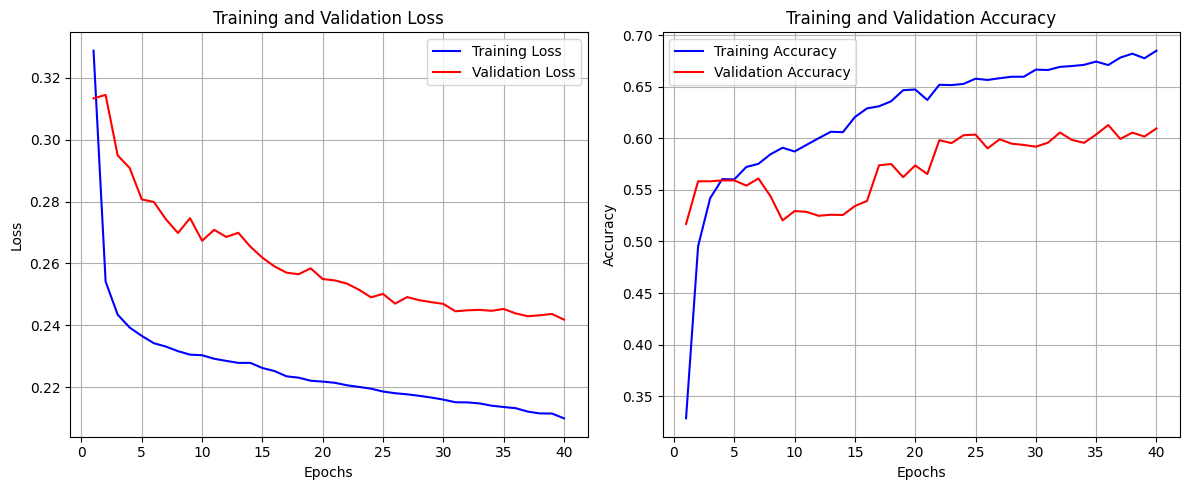

In [ ]:
# CodeGrade Tag Ex4a-i

# Extract the loss and accuracy values for both training and validation
train_loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
train_accuracy = cnn_history.history['precision']
val_accuracy = cnn_history.history['val_precision']

epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()


* **Load the best weights from your model checkpoint, and create plots demonstrating the classification performance for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

### 4.b. LSTM Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

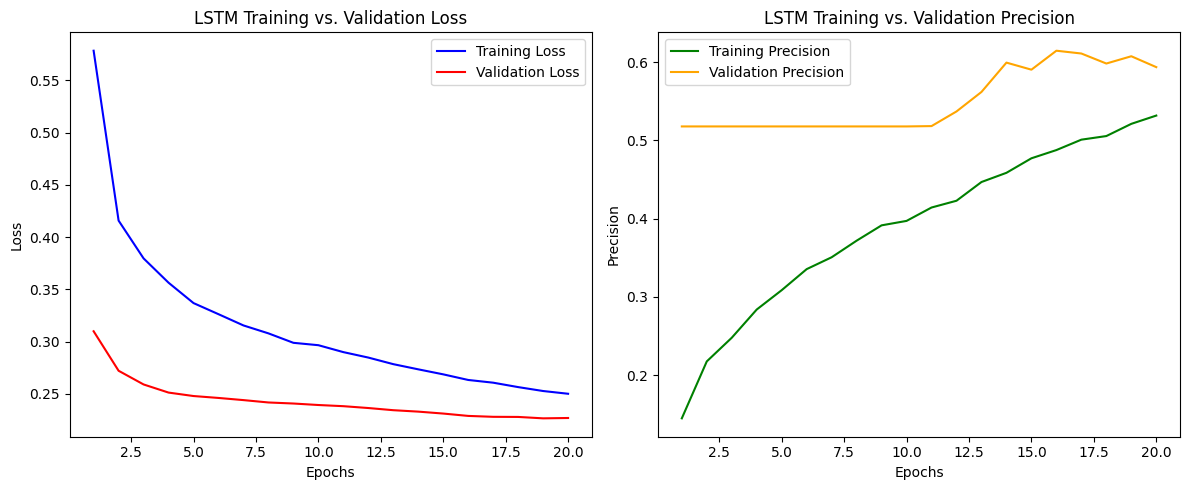

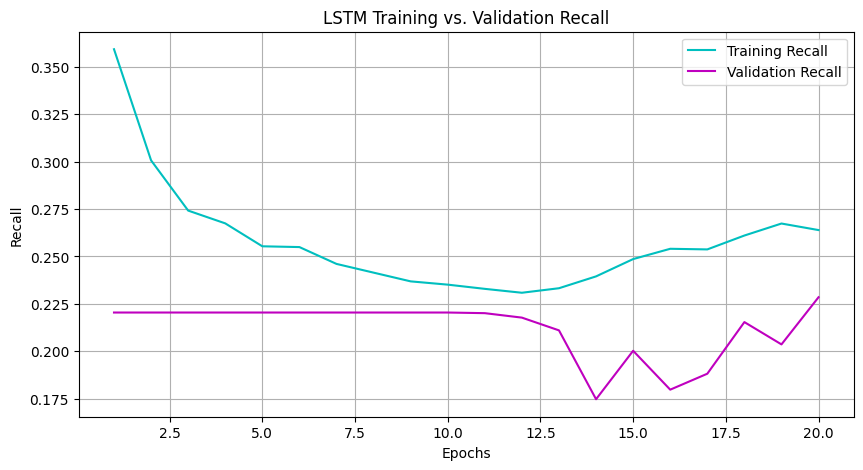

In [ ]:
# CodeGrade Tag Ex4b-i

# Extract relevant metrics
train_loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
train_precision = lstm_history.history['precision']
val_precision = lstm_history.history['val_precision']
train_recall = lstm_history.history['recall']
val_recall = lstm_history.history['val_recall']

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('LSTM Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Precision
plt.subplot(1, 2, 2)
plt.plot(epochs, train_precision, 'g-', label='Training Precision')
plt.plot(epochs, val_precision, 'orange', label='Validation Precision')
plt.title('LSTM Training vs. Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Recall
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_recall, 'c-', label='Training Recall')
plt.plot(epochs, val_recall, 'm-', label='Validation Recall')
plt.title('LSTM Training vs. Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

### 4.c. Produce examples for the report

* First, load the best weights from your checkpoints of both your models.

* Choose a few films from the dataset, plot their posters and print their overviews. Use these example films to demonstrate the classification performance of the CNN model on their posters and of the LSTM model on their overview.

* Be sure to demonstrate the results of the multi-label classification. Compare, for each example film, the top three most probable genres predicted by the CNN and the top three most probable genres predicted by the LSTM with the ground truth genres.

* Include these examples in your report, and critically evaluate on the performance of the model across the classes.

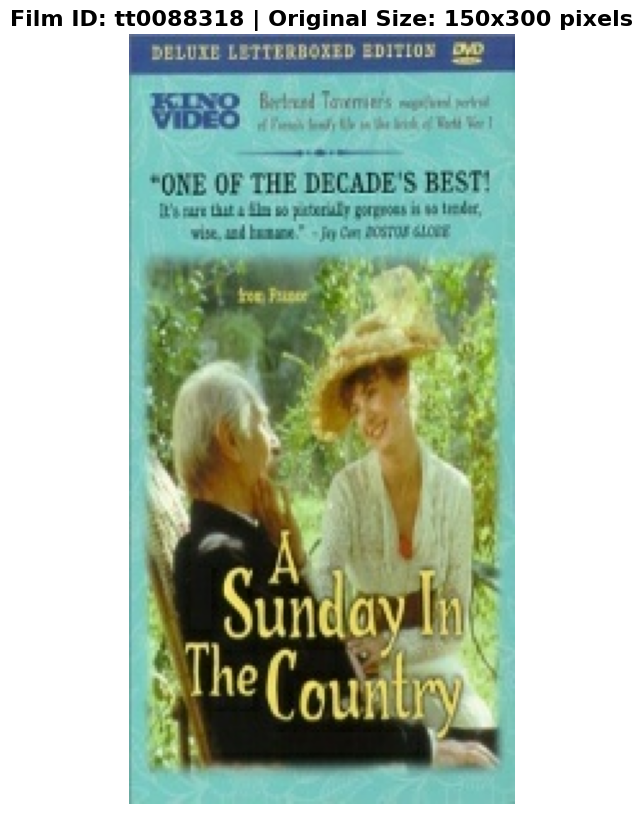

Overview for Film ID tt0088318:
An elderly painter whose son visits with his family on the weekends, is also surprised by a visit from his still-single daughter.



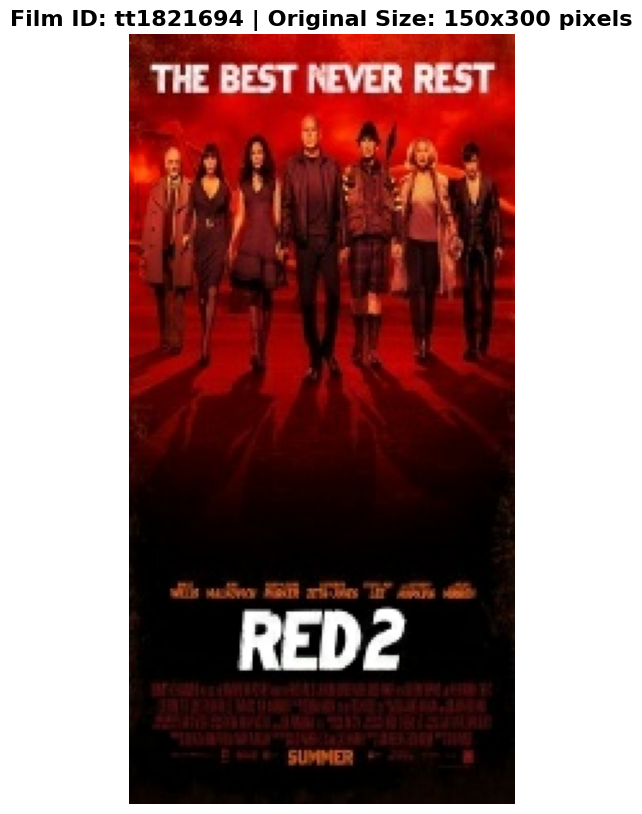

Overview for Film ID tt1821694:
Retired CIA agent Frank Moses reunites his unlikely team of elite operatives for a global quest to track down a missing portable nuclear device.



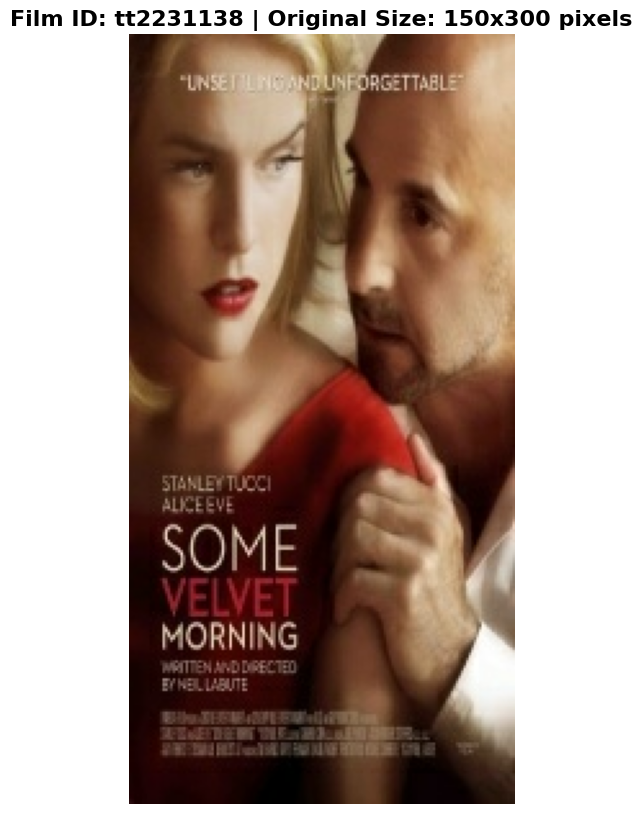

Overview for Film ID tt2231138:
A man surprises his former mistress by claiming to have left his wife. However, before long, a dark history between the two comes into focus.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
Film ID: tt0088318
Actual Genres: ['Drama']
CNN Predicted Genres (Top 3): ['Comedy', 'Drama', 'Romance']
LSTM Predicted Genres (Top 3): ['Drama', 'Comedy', 'Romance']
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Film ID: tt1821694
Actual Genres: ['Action', 'Comedy', 'Crime']
CNN Predicted Genres (Top 3): ['Action', 'Crime', 'Drama']
LSTM Predicted Genres (Top 3): ['Action', 'Comedy', 'Drama']
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Film ID: tt2231138
Actual Genres: ['Drama']
CNN Predicted Genres (Top 3): ['Drama', 'Romance', 'Thriller']
LSTM Predicted Genres (Top 3): ['

In [ ]:
# CodeGrade Tag Ex4c

import random

# Load the best weights for both models
cnn_model.load_weights(checkpoint_cnn_filepath)
lstm_model.load_weights(checkpoint_lstm_filepath)

# Randomly select 3 indices from the test dataset
random_indices = random.sample(range(len(overviews_test)), 3)

# Extract corresponding posters, overviews, labels, and IDs
example_posters = [img_locs_test[0][i] for i in random_indices]
example_overviews = [overviews_test[i] for i in random_indices]
example_labels = labels_test[random_indices]
example_ids = [data_test['Id'].iloc[i] for i in random_indices]

# Loop to display posters and print their overviews
for i in range(len(random_indices)):
    try:
        # Load the poster image
        poster_path = example_posters[i]
        image = tf.io.read_file(poster_path)
        image = tf.image.decode_jpeg(image, channels=3)

        # Display the original image with a large figure size and high DPI
        plt.figure(figsize=(10, 10), dpi=100)  # Larger size and higher DPI for clarity
        plt.imshow(image.numpy())
        plt.axis('off')
        plt.title(
            f"Film ID: {example_ids[i]} | Original Size: {image.shape[1]}x{image.shape[0]} pixels",
            fontsize=16,
            fontweight='bold',
            color='black'
        )
        plt.show()

        # Print the corresponding overview
        print(f"Overview for Film ID {example_ids[i]}:\n{example_overviews[i]}\n")
    except Exception as e:
        print(f"Error loading poster for Film ID {example_ids[i]}: {e}")

for i in range(len(random_indices)):
    try:
        # Preprocess poster for CNN prediction
        poster_path = example_posters[i]
        poster_image = tf.io.read_file(poster_path)
        poster_image = tf.image.decode_jpeg(poster_image, channels=3)
        poster_image = tf.image.resize(poster_image, [64, 64])  # Resize to CNN input size
        poster_image = tf.cast(poster_image, tf.float32) / 255.0  # Normalize

        # Predict with CNN
        cnn_prediction = cnn_model.predict(tf.expand_dims(poster_image, axis=0))

        # Encode and preprocess overview for LSTM prediction
        encoded_overview = encoder([example_overviews[i]])
        lstm_prediction = lstm_model.predict(encoded_overview)

        # Extract actual genres
        true_genres = [genres[idx] for idx, value in enumerate(example_labels[i]) if value == 1]

        # Get top 3 predicted genres for CNN
        top3_cnn_indices = np.argsort(cnn_prediction[0])[-3:][::-1]
        top3_cnn_genres = [genres[idx] for idx in top3_cnn_indices]

        # Get top 3 predicted genres for LSTM
        top3_lstm_indices = np.argsort(lstm_prediction[0])[-3:][::-1]
        top3_lstm_genres = [genres[idx] for idx in top3_lstm_indices]

        # Display predictions and actual genres
        print(f"Film ID: {example_ids[i]}")
        print(f"Actual Genres: {true_genres}")
        print(f"CNN Predicted Genres (Top 3): {top3_cnn_genres}")
        print(f"LSTM Predicted Genres (Top 3): {top3_lstm_genres}")
        print("-" * 50)

    except Exception as e:
        print(f"Error making predictions for Film ID {example_ids[i]}: {e}")